In [8]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import librosa
from librosa.feature import delta
import pickle

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from hmmlearn import hmm

from dtwalign import dtw
import noisereduce as nr
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

# from pyAudioAnalysis import audioBasicIO as aIO
# from pyAudioAnalysis import audioSegmentation as aS
import pysptk
from pysptk.synthesis import MLSADF
from pysptk.synthesis import Synthesizer
from scipy.io import wavfile
import pyworld
from pydub import AudioSegment, effects 
from scipy.io.wavfile import read, write
from pydub.playback import play
from pydub.silence import split_on_silence
# from dtwalign import DeltaAppender
# from dtwalign.dtwalign import MLPG

from nnmnkwii.baseline.gmm import MLPG
from pyworld import decode_spectral_envelope, synthesize

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [12]:
from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
# from nnmnkwii.preprocessing import DeltaAppender
from nnmnkwii.util import trim_zeros_frames, remove_zeros_frames
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG
from os.path import basename, splitext
import sys
import time
from scipy.linalg import solve_triangular

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

### Loading files

In [19]:
with open("paths.txt", "r") as file:
    file_paths = file.read().splitlines()

In [23]:
file_paths

['D:\\ML_Project\\cv-corpus-14.0-2023-06-23-en\\cv-corpus-14.0-2023-06-23\\en\\clips\\common_voice_en_699711.mp3',
 'D:\\ML_Project\\cv-corpus-14.0-2023-06-23-en\\cv-corpus-14.0-2023-06-23\\en\\clips\\common_voice_en_541991.mp3']

In [20]:
src_path = file_paths[0]
dst_path = file_paths[1]

In [21]:
# Load a test audio file
test_audio, fs_test = librosa.load(src_path)
IPython.display.display(Audio(test_audio, rate=fs_test))

In [24]:
# Load a test audio file
target_audio, fs_target = librosa.load(dst_path)
IPython.display.display(Audio(target_audio, rate=fs_target))

In [26]:
with open("gmm.pkl", "rb") as file:
    gmm = pickle.load(file)

### Preprocessing 

In [27]:
trimmed_test, _ = librosa.effects.trim(test_audio, top_db = 20)
test_norm = librosa.util.normalize(trimmed_test)

In [28]:
trimmed_target, _ = librosa.effects.trim(target_audio, top_db = 20)
target_norm = librosa.util.normalize(trimmed_target)

In [29]:
test_clean = nr.reduce_noise(test_norm, sr = fs_test)
target_clean = nr.reduce_noise(target_norm, sr = fs_target)

In [30]:
IPython.display.display(Audio(test_clean, rate=fs_test))

In [31]:
IPython.display.display(Audio(target_clean, rate=fs_target))

In [32]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 100 # number of utterances to be used.
test_size = 0.1
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

In [33]:
def collect_features(x, fs):
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    spectrogram = trim_zeros_frames(spectrogram)
    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    
    return mc

In [34]:
test_mfccs = collect_features(test_clean, fs_test)
target_mfccs = collect_features(target_clean, fs_target)

In [35]:
scaler_test = MinMaxScaler()
scaler_test = scaler_test.fit(test_mfccs)
test = scaler_test.transform(test_mfccs)

In [38]:
scaler_target = MinMaxScaler()
scaler_target = scaler_target.fit(target_mfccs)
dst = scaler_test.transform(target_mfccs)

In [39]:
test_shape = test.shape
dst_shape = dst.shape
max_frames = max(test_shape[0], dst_shape[0])

# Pad zeros for src and dst
test_padded = np.pad(test, ((0, max_frames - test_shape[0]), (0, 0)), 'constant')
dst_padded = np.pad(dst, ((0, max_frames - dst_shape[0]), (0, 0)), 'constant')

# test_padded = test_padded.T
# dst_padded = dst_padded.T

# Now, src_padded and dst_padded have the same shape
print("test_padded shape:", test_padded.shape)
print("dst_padded shape:", dst_padded.shape)

test_padded shape: (436, 25)
dst_padded shape: (436, 25)


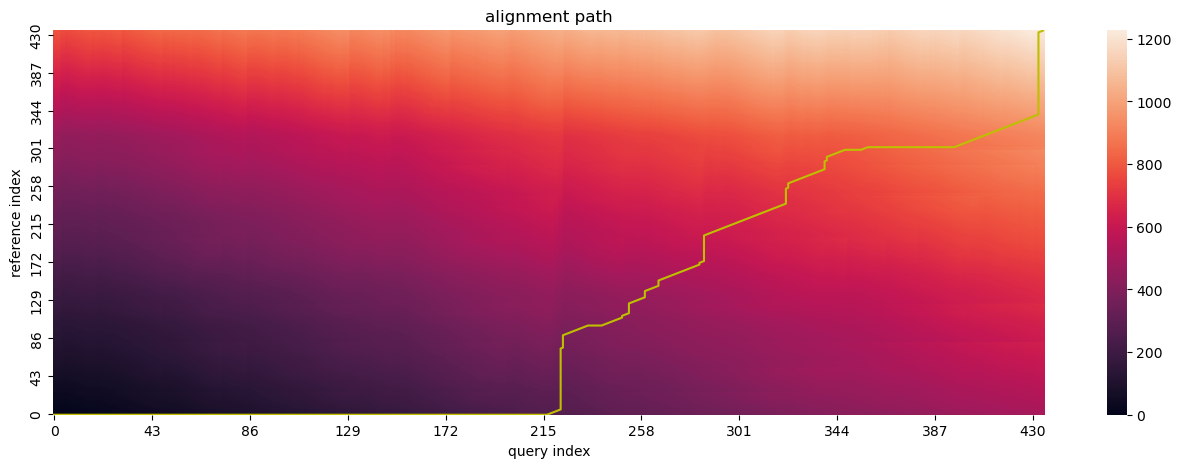

In [40]:
res = dtw(test_padded, dst_padded)
res.plot_path()

In [47]:
x_path = res.path[:, 0]
y_path = res.path[:, 1]
x_warping_path = res.get_warping_path(target="query")

In [48]:
test_aligned = test_padded[x_warping_path]
dst_aligned = dst_padded

In [49]:
def _delta(x, window):
    return np.correlate(x, window, mode="same")

def delta(x, window):
    """Returns delta features given a static features and a window.

    Args:
        x (numpy.ndarray): Input static features, of shape (``T x D``).
        window (numpy.ndarray): Window coefficients.

    Returns:
        (ndarray): Delta features, shape (``T x D``).

    Examples:
        >>> from nnmnkwii.util import delta
        >>> T, static_dim = 10, 24
        >>> x = np.random.rand(T, static_dim)
        >>> window = np.array([-0.5, 0.0, 0.5]) # window for delta feature
        >>> y = delta(x, window)
        >>> assert x.shape == y.shape
    """
    T, D = x.shape
    y = np.zeros_like(x)
    for d in range(D):
        y[:, d] = _delta(x[:, d], window)
    return y

class UtteranceWiseTransformer(object):
    def transform(self, X, lengths=None):
        assert X.ndim == 3
        N, T, D = X.shape
        Y = np.zeros(self.get_shape(X), dtype=X.dtype)
        for idx, x in enumerate(X):
            if lengths is None:
                x = trim_zeros_frames(x)
            else:
                x = x[:lengths[idx]]
            y = self.do_transform(x)
            Y[idx][:len(y)] = y
        return Y

    def get_shape(self, X):
        raise NotImplementedError
    
class DeltaAppender(UtteranceWiseTransformer):
    """Append delta features.

    Given a ``N x T x D`` array, features of multiple utterances,
    transform features into static + delta features for each utterance.

    Attributes:
        windows (list): A sequence of windows. See
          :func:`nnmnkwii.functions.mlpg` for what window means.
    """

    def __init__(self, windows):
        self.windows = windows

    def get_shape(self, X):
        N, T, D = X.shape
        return (N, T, D * len(self.windows))

    def do_transform(self, x):
        features = []
        for _, _, window in self.windows:
            features.append(delta(x, window))
        combined_features = np.hstack(features)
        return combined_features


In [50]:
static_dim = test_aligned.shape[-1]
use_delta = False
if use_delta:
    test_aligned = DeltaAppender(windows).transform(test_aligned)
    dst_aligned = DeltaAppender(windows).transform(dst_aligned)

### Testing

In [51]:
paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=True)

In [52]:
test_aligned = paramgen.transform(test_aligned)

In [53]:
scaler_converted = MinMaxScaler()
scaler_converted = scaler_converted.fit(test_aligned)
XY_test_converted = scaler_converted.transform(test_aligned)

In [54]:
XY_test_converted_invert = scaler_converted.inverse_transform(XY_test_converted)
XY_test_inverse = librosa.feature.inverse.mfcc_to_audio(XY_test_converted_invert)
IPython.display.Audio(XY_test_inverse, rate=fs_test)

In [55]:
XY_test_inverse_nr = nr.reduce_noise(XY_test_inverse, sr = fs_target)
IPython.display.Audio(XY_test_inverse_nr, rate=fs_test)